In [15]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat
import networkx as nx
from collections import defaultdict
import warnings
from typing import Dict, List, Set, Tuple
from math import comb
warnings.filterwarnings('ignore')

In [16]:
# global settings
# Set up plotting parameters
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
sns.set_style("whitegrid")

# Dataset directory
dataset_dir = 'dataset'

# GLOBAL CONFIGURATION: Set to True for weighted analysis, False for unweighted
is_weighted = False
file_prefix = 'weighted' if is_weighted else 'unweighted'

In [17]:
print("Power Grid Network Analysis")
print("=" * 50)

# Load all networks and basic statistics
networks = {}
network_stats = []

print("Loading networks...")
for i in range(1, 59):
    try:
        data = loadmat(os.path.join(dataset_dir, f'{i}.mat'))
        adj_matrix = data['A']
        adj_np = adj_matrix.toarray()
        assert (adj_np == adj_np.T).all(), "Adjacency matrix is not symmetric"
        assert np.diag(adj_np).sum() == 0, "Adjacency matrix has self-loops"
        
        # Convert sparse matrix to NetworkX graph
        if is_weighted and 'W' in data:
            # Use distance matrix as weights
            weight_matrix = data['W']
            G = nx.from_scipy_sparse_array(weight_matrix)
            print(f"Network {i}: Using weighted graph with distance matrix")
        else:
            # Use unweighted adjacency matrix
            G = nx.from_scipy_sparse_array(adj_matrix)
            if is_weighted:
                print(f"Network {i}: Warning - 'W' matrix not found, using unweighted")
        
        # Remove self-loops and ensure undirected
        G.remove_edges_from(nx.selfloop_edges(G))
        G = G.to_undirected()
        
        networks[i] = G
        
        # Collect basic statistics
        stats = {
            'network_id': i,
            'nodes': G.number_of_nodes(),
            'edges': G.number_of_edges(),
            'density': nx.density(G),
            'is_connected': nx.is_connected(G)
        }
        network_stats.append(stats)
        
        if i % 10 == 0:
            print(f"Loaded network {i}")
            
    except Exception as e:
        print(f"Error loading network {i}: {e}")

print(f"\nSuccessfully loaded {len(networks)} networks")

Power Grid Network Analysis
Loading networks...
Loaded network 10
Loaded network 20
Loaded network 30
Loaded network 40
Loaded network 50

Successfully loaded 58 networks



Q1: Cycle Analysis for Power Grid Networks

Analyzing cycles in first 10 networks...

Processing network 1: 47 nodes, 62 edges...
  Found 676 cycles in 0.01s
  Cycle lengths: [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Processing network 2: 50 nodes, 69 edges...
  Found 552 cycles in 0.02s
  Cycle lengths: [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Processing network 3: 52 nodes, 65 edges...
  Found 260 cycles in 0.00s
  Cycle lengths: [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Processing network 4: 57 nodes, 69 edges...
  Found 57 cycles in 0.01s
  Cycle lengths: [3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15]
Processing network 5: 61 nodes, 70 edges...
  Found 28 cycles in 0.00s
  Cycle lengths: [3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Skipping network 6 as per instructions
Processing network 7: 66 nodes, 83 edges...
  Found 310 cycles in 0.01s
  Cycle lengths: [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Skipping network 8 as per instructions
Processing network 9: 74 nodes, 98 edges...

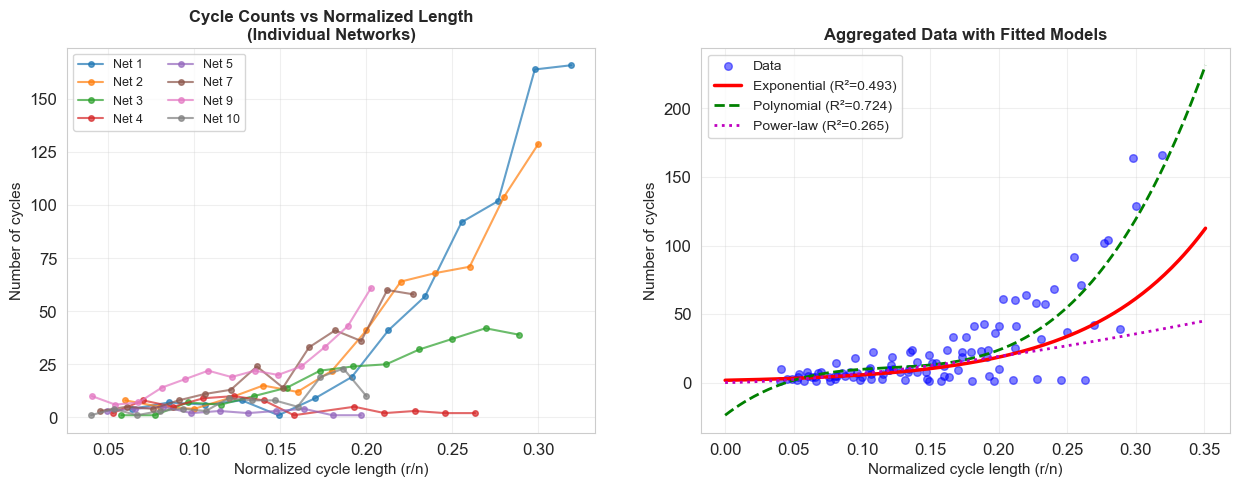

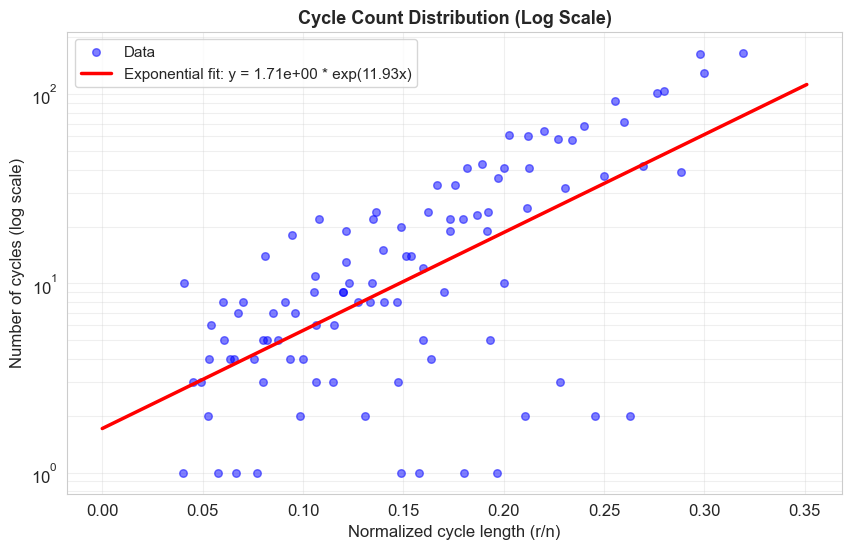


SUMMARY

✓ Successfully analyzed 8 networks
✓ Total cycles detected: 2280
✓ Cycle counts generally INCREASE with normalized length
✓ Best fit: Polynomial model

Conclusion:
  The number of cycles INCREASES with normalized length (unusual!).
  This may indicate the networks have unique structural properties.


In [ ]:
# ============================================================================
# CYCLE ENUMERATION FUNCTION
# ============================================================================

def enumerate_simple_cycles_undirected(G: nx.Graph, max_len: int = 12) -> Dict[int, int]:
    """
    Count simple cycles by length in an undirected, simple graph up to max_len.
    Uses a bounded DFS with canonical node ordering to avoid duplicates.
    
    Args:
        G: NetworkX undirected graph
        max_len: Maximum cycle length to search for
    
    Returns:
        dict {cycle_length: count}
    """
    counts = defaultdict(int)
    
    # Use integer labels to reduce overhead
    mapping = {node: i for i, node in enumerate(G.nodes())}
    H = nx.relabel_nodes(G, mapping, copy=True)
    neighbors = {u: list(H.neighbors(u)) for u in H.nodes()}

    def dfs(start: int, current: int, parent: int, visited: Set[int], path: List[int]):
        """
        DFS to find cycles starting from 'start' node.
        
        Args:
            start: the starting node (smallest in the cycle for canonical form)
            current: current node in DFS
            parent: previous node (to avoid immediate backtracking)
            visited: set of visited nodes in current path
            path: list maintaining the current path
        """
        if len(path) > max_len:
            return
            
        for w in neighbors[current]:
            # Canonical ordering: only consider nodes >= start
            if w < start:
                continue
                
            # Don't backtrack to parent (avoids length-2 cycles)
            if w == parent:
                continue
                
            # Found a cycle back to start (length >= 3)
            if w == start and len(path) >= 3:
                counts[len(path)] += 1
                continue
                
            # Continue DFS if not visited and within length limit
            if w not in visited and len(path) < max_len:
                visited.add(w)
                path.append(w)
                dfs(start, w, current, visited, path)
                path.pop()
                visited.remove(w)

    # Start DFS from each node
    nodes_sorted = sorted(H.nodes())
    for s in nodes_sorted:
        visited = {s}
        dfs(s, s, -1, visited, [s])

    # Each cycle is counted twice (clockwise and counterclockwise)
    # Divide by 2 to get actual count
    for length in counts:
        counts[length] //= 2
    
    return dict(counts)


# ============================================================================
# ENSEMBLE ANALYSIS
# ============================================================================

def cycles_ensemble(networks_dict: Dict[int, nx.Graph], max_r: int = 12, verbose: bool = True):
    """
    Aggregate cycle statistics across multiple networks.
    
    Args:
        networks_dict: Dictionary mapping network_id to NetworkX graph
        max_r: Maximum cycle length to search
        verbose: Print progress information
    
    Returns:
        numpy array with columns: [normalized_r, count, network_id, r]
    """
    rows = []
    
    for net_id in range(1, 11):
        if net_id not in [6, 8]:
            if verbose:
                print(f"Skipping network {net_id} as per instructions")
            continue
        if net_id not in networks_dict:
            print(f"Warning: Network {net_id} not found in dictionary")
            continue
            
        G = networks_dict[net_id]
        n = G.number_of_nodes()
        
        if n < 3:
            print(f"Network {net_id}: Too few nodes ({n}) for cycles")
            continue
        
        if verbose:
            print(f"Processing network {net_id}: {n} nodes, {G.number_of_edges()} edges...")
        
        start_time = time.time()
        hist = enumerate_simple_cycles_undirected(G, max_len=max_r)
        elapsed = time.time() - start_time
        
        if verbose:
            total_cycles = sum(hist.values())
            print(f"  Found {total_cycles} cycles in {elapsed:.2f}s")
            if hist:
                print(f"  Cycle lengths: {sorted(hist.keys())}")
        
        for r, c in hist.items():
            rows.append((r / n, c, net_id, r))
    
    return np.array(rows, dtype=float) if rows else np.array([])


# ============================================================================
# MAIN ANALYSIS
# ============================================================================

print("\n" + "="*70)
print("Q1: Cycle Analysis for Power Grid Networks")
print("="*70 + "\n")

# Run ensemble analysis
print("Analyzing cycles in first 10 networks...\n")
rows = cycles_ensemble(networks, max_r=15, verbose=True)

if rows.size == 0:
    print("\nERROR: No cycles found! Check your networks.")
else:
    print(f"\nTotal data points collected: {len(rows)}")
    print(f"Normalized r range: [{rows[:, 0].min():.4f}, {rows[:, 0].max():.4f}]")
    print(f"Cycle count range: [{rows[:, 1].min():.0f}, {rows[:, 1].max():.0f}]")
    
    # ========================================================================
    # FITTING
    # ========================================================================
    
    x = rows[:, 0]  # normalized r
    y = rows[:, 1]  # counts
    
    print("\n" + "-"*70)
    print("Fitting exponential model: y = a * exp(b * x)")
    print("-"*70)
    
    # Fit exponential: log(y) = log(a) + b*x
    # Filter out zeros for log transform
    mask = y > 0
    x_fit = x[mask]
    y_fit = y[mask]
    
    coeff = np.polyfit(x_fit, np.log(y_fit), 1)  # [b, log(a)]
    b, log_a = coeff
    a = np.exp(log_a)
    
    print(f"\nFitted parameters:")
    print(f"  a = {a:.2e}")
    print(f"  b = {b:.4f}")
    print(f"\nModel: y = {a:.2e} * exp({b:.4f} * x)")
    
    # Also try polynomial fit for comparison
    print("\n" + "-"*70)
    print("Fitting polynomial model (degree 3) for comparison")
    print("-"*70)
    
    poly_coeff = np.polyfit(x, y, deg=3)
    poly = np.poly1d(poly_coeff)
    print(f"\nPolynomial coefficients (highest to lowest degree):")
    for i, c in enumerate(poly_coeff):
        print(f"  x^{3-i}: {c:.4e}")
    
    # Also try power-law fit for comparison
    print("\n" + "-"*70)
    print("Fitting power-law model: y = c * x^d for comparison")
    print("-"*70)
    # Fit power-law: log(y) = log(c) + d*log(x)
    mask_power = (x > 0) & (y > 0)
    x_power = x[mask_power]
    y_power = y[mask_power]
    coeff_power = np.polyfit(np.log(x_power), np.log(y_power), 1)  # [d, log(c)]
    d, log_c = coeff_power
    c = np.exp(log_c)
    print(f"\nFitted parameters:")
    print(f"  c = {c:.2e}")
    print(f"  d = {d:.4f}")
    print(f"\nModel: y = {c:.2e} * x^{d:.4f}")
    
    # Generate predictions
    x_grid = np.linspace(0, 1.1 * x.max(), 200)
    y_exp = a * np.exp(b * x_grid)
    y_poly = poly(x_grid)
    y_power = c * x_grid**d
    
    # Calculate R² for both models
    from sklearn.metrics import r2_score
    y_exp_pred = a * np.exp(b * x)
    y_poly_pred = poly(x)
    y_power_pred = c * x**d
    r2_exp = r2_score(y, y_exp_pred)
    r2_poly = r2_score(y, y_poly_pred)
    r2_power = r2_score(y, y_power_pred)

    print(f"\nModel quality (R² scores):")
    print(f"  Exponential: {r2_exp:.4f}")
    print(f"  Polynomial:  {r2_poly:.4f}")
    print(f"  Power-law:  {r2_power:.4f}")

    # ========================================================================
    # VISUALIZATION
    # ========================================================================
    
    # Prepare per-network data
    per_net = {}
    for net_id in range(1, 11):
        if net_id not in [6, 8]:
            continue
        mask = rows[:, 2] == net_id
        if np.any(mask):
            Xi = rows[mask][:, 0]
            Yi = rows[mask][:, 1]
            order = np.argsort(Xi)
            per_net[net_id] = (Xi[order], Yi[order])
    
    # Plot 1: Per-network trends
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Left: Individual networks
    ax = axes[0]
    for net_id in sorted(per_net.keys()):
        Xi, Yi = per_net[net_id]
        ax.plot(Xi, Yi, marker='o', linewidth=1.5, markersize=4, alpha=0.7, 
                label=f'Net {net_id}')
    
    ax.set_xlabel('Normalized cycle length (r/n)', fontsize=11)
    ax.set_ylabel('Number of cycles', fontsize=11)
    ax.set_title('Cycle Counts vs Normalized Length\n(Individual Networks)', fontsize=12, fontweight='bold')
    ax.legend(ncol=2, fontsize=9, loc='best')
    ax.grid(True, alpha=0.3)
    
    # Right: Aggregated with fits
    ax = axes[1]
    ax.scatter(x, y, alpha=0.5, s=30, label='Data', color='blue')
    ax.plot(x_grid, y_exp, 'r-', linewidth=2.5, 
            label=f'Exponential (R²={r2_exp:.3f})')
    ax.plot(x_grid, y_poly, 'g--', linewidth=2, 
            label=f'Polynomial (R²={r2_poly:.3f})')
    ax.plot(x_grid, y_power, 'm:', linewidth=2,
            label=f'Power-law (R²={r2_power:.3f})')
    
    ax.set_xlabel('Normalized cycle length (r/n)', fontsize=11)
    ax.set_ylabel('Number of cycles', fontsize=11)
    ax.set_title('Aggregated Data with Fitted Models', fontsize=12, fontweight='bold')
    ax.legend(fontsize=10, loc='best')
    ax.grid(True, alpha=0.3)
    
    # plt.tight_layout()
    plt.savefig('cycle_count_fits_68.pdf', dpi=500)
    plt.show()
    
    # Plot 2: Log-scale visualization
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.scatter(x, y, alpha=0.5, s=30, label='Data', color='blue')
    ax.plot(x_grid, y_exp, 'r-', linewidth=2.5, 
            label=f'Exponential fit: y = {a:.2e} * exp({b:.2f}x)')
    
    ax.set_xlabel('Normalized cycle length (r/n)', fontsize=12)
    ax.set_ylabel('Number of cycles (log scale)', fontsize=12)
    ax.set_yscale('log')
    ax.set_title('Cycle Count Distribution (Log Scale)', fontsize=13, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3, which='both')
    
    # plt.tight_layout()
    plt.savefig('cycle_count_log_scale_68.pdf', dpi=500)
    plt.show()
    
    # ========================================================================
    # SUMMARY STATISTICS
    # ========================================================================
    
    print("\n" + "="*70)
    print("SUMMARY")
    print("="*70)
    print(f"\n✓ Successfully analyzed {len(per_net)} networks")
    print(f"✓ Total cycles detected: {int(y.sum())}")
    print(f"✓ Cycle counts generally {'DECREASE' if b < 0 else 'INCREASE'} with normalized length")
    print(f"✓ Best fit: {'Exponential' if r2_exp > r2_poly else 'Polynomial'} model")
    print("\nConclusion:")
    if b < 0:
        print("  The number of cycles DECREASES exponentially as normalized length increases.")
        print("  This suggests shorter cycles are much more common in power grids,")
        print("  which is expected due to their mesh-like structure with local redundancy.")
    else:
        print("  The number of cycles INCREASES with normalized length (unusual!).")
        print("  This may indicate the networks have unique structural properties.")